<a href="https://colab.research.google.com/github/eborin/SSL-course/blob/main/10_minerva_SimCLR-STL10-downstream_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[View Source Code](https://github.com/eborin/SSL-course/blob/main/10_minerva_SimCLR-STL10-downstream_task.ipynb)

# Using Pretrained Backbones on the Downstream Task

This notebook demonstrates how to load pretrained backbones and apply them to solve the downstream task. 
Specifically, it guides you through the process of loading a ResNet-18 backbone pretrained in the tutorial `09_minerva_SimCLR-STL10-backbone_pretrain.ipynb` and using it to tackle the STL10 image classification task.

## 1. Introduction

### 1.1 Objective

The primary goal of this tutorial is to demonstrate how to load and use pretrained backbones to tackle the downstream task.
Additionally, we will compare the performance of downstream models using three types of backbones:

* From Scratch – randomly initialized, i.e., with no pretraining;

* SimCLR Pretrained – pretrained using the SimCLR self-supervised approach; and

* ImageNet Pretrained – pretrained on the ImageNet dataset


### 1.2 What we will cover

We will begin by setting up the dataloader for the downstream task.
Then, we will discuss how to build the model for the downstream task. 
Next, we will build and train multiple models using from scratch and pretrained backbones.
Finally, we will evaluate their performance on the test dataset.

| **Topic** | **Contents** |
| ----- | ----- |
| [**2. Basic Setup**](#sec_2) | Import the necessary modules (PyTorch, Torchvision, and PyTorch Lightning), and define the key variables that control the training process.  |
| [**3. Setting Up the Data Module**](#sec_3) | Set up the data module for the training and evaluation processes. |
| [**4. Combining the Backbone and the Prediction Head**](#sec_4) | Develop code to combine the backbone with prediction heads to construct a supervised machine learning model for solving the downstream task. |
| [**5. Training the Models**](#sec_5) | Build and train several models. |
| [**6. Evaluating the models**](#sec_6) | Evaluate the trained models on the test set. |
| [**7. Exercises**](#sec_7) | Suggested Exercises. |

### 1.3 Where can you get help?

In addition to discussing with your colleagues or the course professor, you might also consider:

* Minerva: check the [Minerva docs](https://discovery-unicamp.github.io/Minerva/).

* Lightning: check the [Lightning documentation](https://lightning.ai/docs/overview/getting-started) and research or post Lightning related question on the [PyTorch Lightning forum](https://lightning.ai/forums/).

* PyTorch: check the [PyTorch documentation](https://pytorch.org/docs/stable/index.html) and research or post PyTorch related question on the [PyTorch developer forums](https://discuss.pytorch.org/).

## <a id="sec_2">2. Basic setup</a>

### 2.1 Setting the main variables

The following variables influence the execution time of this notebook. 
You may want to adjust them if you are not using high-performance hardware (e.g., fast GPUs):

* `n_epochs`: Specifies the number of training epochs for each model.

* `n_version`: Determines how many versions of each model will be trained. Training multiple versions helps assess the impact of randomness on model performance.

* `DL_BATCH_SIZE`: Sets the batch size used during training.

* `DL_NUM_WORKERS`: Defines the number of parallel threads/processes the dataloader uses to prefetch and preprocess data during training.

* `output_csv_filename`: Specifies the name of the CSV file where evaluation results (accuracies of each model) will be recorded.


In [1]:
## General configuration variables

# Maximum number of epochs to train the downstream model
n_epochs = 20

# Number of model versions to train. Each model configuration will be trained n_versions times. 
n_versions = 3

# Train dataloader parameters
DL_BATCH_SIZE=32
DL_NUM_WORKERS=8

# Output statistics
output_csv_filename = "10_minerva-SimCLR-STL10-downstream_task_results.csv"

### 2.2 Installing Lightining and Minerva modules

The code below attempts to import Minerva and installs it if it is not already available.
Since Minerva depends on the Lightning module, Lightning will also be installed automatically when Minerva is installed.

In [2]:
try:
    import minerva
except:
    try:
        #Try to install it and import again
        print("[INFO]: Could not import the minerva module. Trying to install it!")
        !pip install -q minerva-ml
        import minerva
        print("[INFO]: It looks like minerva was successfully imported!")
    except:
        raise Exception("[ERROR] Couldn't find the minerva module ... \n" +
                        "Please, install it before running the notebook.\n"+
                        "You might want to install the modules listed at requirements.txt\n" +
                        "To do so, run: \"pip install -r requirements.txt\"")

### 2.3 Importing basic modules

In [3]:
# Import PyTorch
import torch

# Import torchvision
import torchvision

# Import lightning
import lightning

# Import minerva
import minerva

# Check versions
# Note: your PyTorch version shouldn't be lower than 1.10.0 and torchvision version shouldn't be lower than 0.11
print(f"PyTorch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"Lightning version: {lightning.__version__}")
#print(f"Minerva version: {M.__version__}") ## TODO

# Import matplotlib for visualization
import matplotlib.pyplot as plt

PyTorch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
Lightning version: 2.5.1


## <a id="sec_3">3. Setup the Data Module</a>

### 3.1 Download and instantiate the train and test datasets

As in previous tutorials, we will use the `torchvision` module to download the datasets.
Additionally, we will define a data transformation pipeline to convert samples from PIL images to tensors and normalize them using the dataset's mean and standard deviation.

In [4]:
# Torchvision transforms
from torchvision.transforms.v2 import Compose, ToImage, ToDtype, Normalize

# STL10 statistics for the train split. 
# - Note: If you would like to compute these statistics for your own dataset, refer 
#         to the discussion in tutorial 05_pytorch_transfer_learning.ipynb.
stl10_train_mean  = torch.tensor([0.4467, 0.4398, 0.4066])
stl10_train_std = torch.tensor([0.2603, 0.2566, 0.2713])

# Build the data transform pipeline to convert from PIL images to tensors and normalize the data. 
transform_pipeline = Compose([
    ToImage(), 
    ToDtype(torch.float32, scale=True),
    Normalize(mean=stl10_train_mean, std=stl10_train_std)
])

train_dataset = torchvision.datasets.STL10(root="data", 
                                           split="train",  
                                           download=True,
                                           transform=transform_pipeline)

test_dataset = torchvision.datasets.STL10(root="data", 
                                           split="test",  
                                           download=True,
                                           transform=transform_pipeline)

class_names = train_dataset.classes
print("Class names:", class_names)

Class names: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']


### 3.2 Setup the data module

Finally, we will split the training dataset into training and validation subsets, and create a Minerva data module to organize the data and set up the corresponding dataloaders.

In [5]:
from torch.utils.data import random_split
from minerva.data.data_modules.base import MinervaDataModule

# Split the training dataset into train and validation subsets
torch.manual_seed(42)
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_set, val_set = random_split(train_dataset, [train_size, val_size])

# Create the data module.
datamodule = MinervaDataModule(name="STL10",
                               train_dataset=train_set, 
                               val_dataset=val_set, 
                               test_dataset=test_dataset,
                               batch_size=DL_BATCH_SIZE, 
                               num_workers=DL_NUM_WORKERS)

## <a id="sec_4">4. Combining the Backbone and the Prediction Head</a>

In this section, we will develop the code to build a model for the downstream task.

Specifically, we will create functions to load pretrained ResNet18 backbones from checkpoint files and combine them with a prediction head to form a supervised model.

### 4.1 Loading a pretrained backbone

The pretrained backbone weights are stored in a checkpoint file, along with the projection head weights and other information from the Minerva SimCLR model.

To load these weights, you must first instantiate an equivalent SimCLR model—using the same backbone and projection head architecture—and then call the `load_from_checkpoint()` method.

The code below includes functions to generate backbones and projection heads that are structurally identical to those used when the checkpoints were originally created.

In [6]:
from torchvision.models import resnet18

def generate_backbone(weights=None):
    backbone = resnet18(weights=weights)
    backbone.fc = torch.nn.Identity()
    return backbone

def generate_proj_head(backbone_out_dim=512, output_dim=128):
    return torch.nn.Sequential(
        torch.nn.Linear(backbone_out_dim, 4*output_dim), # Resnet output => 4*hidden_dim
        torch.nn.ReLU(inplace=True),
        torch.nn.Linear(4*output_dim, output_dim))

The function below instantiates a Minerva `SimCLR` model using the same backbone and projection head architectures as in the previous tutorial. 
It then loads the weights from a checkpoint file and returns the model's backbone.

In [7]:
from minerva.models.ssl.simclr import SimCLR

def loadPretrainedBackbone(ckpt_filename):
    pretext_model = SimCLR.load_from_checkpoint(ckpt_filename,
                                                backbone=generate_backbone(),
                                                projection_head=generate_proj_head())
    return pretext_model.backbone

#### **Note on checkpointing**

The code above uses the Lightning `load_from_checkpoint()` method to restore model weights from a checkpoint. 
To do this, we must reconstruct the model architecture exactly as it was when the checkpoint was created—which is why we needed to define both the backbone and the projection head.

Alternatively, you could load the checkpoint using `torch.load()` to retrieve its contents as a dictionary, and then manually extract the backbone weights. 
More information on extracting specific components, such as the backbone, from a PyTorch Lightning checkpoint is available in the [Lightning documentation](https://lightning.ai/docs/pytorch/stable/common/checkpointing_basic.html#nn-module-from-checkpoint).

Lastly, it is worth noting that Lightning provides an [experimental API for customizing the checkpointing process](https://lightning.ai/docs/pytorch/1.6.3/common/checkpointing.html#customize-checkpointing). 
This API could be used during SimCLR pretraining to save only the backbone weights, streamlining the process for downstream tasks.

### 4.2 Building a SimpleSupervisedModel model from a given backbone

Now, we will combine the pretrained backbone with a prediction head to construct a model for the downstream task.

To achieve this, we will create an MLP prediction head and attach it to the pretrained backbone using Minerva's `SimpleSupervisedModel` class.

#### 4.2.1 Generating the prediction head

We will use a simple MLP consisting of two linear layers with a ReLU activation in between.
The code below defines this architecture using `torch.nn.Sequential()`.

In [8]:
import torch

def generate_pred_head(backbone_out_dim=512):
    return torch.nn.Sequential(
        torch.nn.Linear(backbone_out_dim, 512),
        torch.nn.ReLU(),
        torch.nn.Linear(512, len(class_names))
    )

#### 4.2.2 Building the SimpleSupervisedModel

When constructing the `SimpleSupervisedModel`, we will use `CrossEntropyLoss()` as the loss function and include accuracy metrics to monitor the model's performance on both the training and test sets.

In [9]:
from minerva.models.nets.base import SimpleSupervisedModel
from torchmetrics import Accuracy

# Build a simple supervised model for STL10 using a given backbone
def build_SimpleSupervisedModel(backbone, hidden_dim=512):
  return SimpleSupervisedModel(
    backbone=backbone,
    fc=generate_pred_head(),
    loss_fn=torch.nn.CrossEntropyLoss(),
    train_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    val_metrics  ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
    test_metrics ={"accuracy": Accuracy("multiclass", num_classes=len(class_names))},
  )

## <a id="sec_5">5. Training the models</a>

Now, we will build and train several models to evaluate the impact of pretraining on the performance of a downstream task.
Specifically, we will compare models that use pretrained backbones with those that use randomly initialized (untrained) backbones—referred to as from scratch models.

Let’s begin by creating a dictionary to store all the models.

In [10]:
models = {}

### 5.1 Downloading Minerva SimCLR checkpoints

We will use checkpoints generated by SimCLR in the tutorial `09_minerva_SimCLR-STL10-backbone_pretrain.ipynb`.

If you did not save your own checkpoints, you can download a pre-generated set that I have made available on my webpage.
For convenience, the code below will automatically download and extract the checkpoints.

This particular zip file contains model checkpoints saved every 20 epochs.

In [11]:
import os
filename = '09_minerva_SimCLR_STL10-checkpoints-20-100.zip'

if not os.path.exists(filename):
    # Download the zip file with checkpoints
    import urllib.request
    url = 'https://www.ic.unicamp.br/~edson/disciplinas/mo810/2025-1s/09_minerva_SimCLR_STL10-checkpoints-20-100.zip'
    urllib.request.urlretrieve(url, filename)

if not os.path.exists("logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/"):
    # Unzip the checkpoint file
    import zipfile
    with zipfile.ZipFile(filename, 'r') as zip_ref:
        zip_ref.extractall('.')

After running the code above, you should see the file `09_minerva_SimCLR_STL10-checkpoints-20-100.zip` in your local directory.
You will also find several checkpoint files inside the `logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/` folder, each one from a different training epoch.

### 5.2 Selecting the SimCLR checkpoints to read from

The code below searches for checkpoint files that match a specified filename pattern, generates a basename to identify each checkpoint, and stores them in a list.

If you have multiple checkpoints (e.g., saved every 10 epochs), you can modify the filename pattern to load additional checkpoints and evaluate how different stages of pretraining impact final model performance.

> **Important**: If you modify the filename pattern, make sure to update the code that generates the `model_basename` accordingly, so the model can be properly identified. 
    In the following example, we extract the epoch number from the checkpoint filename to construct the model’s basename.

> **Hint**: If you downloaded `09_minerva_SimCLR_STL10-checkpoints-20-100.zip`, you can uncomment the provided line to evaluate all checkpoints, rather than evaluating only the one corresponding to the 99th epoch.

In [12]:
import glob

# Search for the checkpoint file associated with epoch 99.
model_ckpt_files = glob.glob("logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=99*")

# Uncomment the following line to evaluate all the checkpoints
# model_ckpt_files = glob.glob("logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch*.ckpt")

# Build a list with (checkpoint basename; checkpoint filename) tuples.
checkpoints_list = []
for f in model_ckpt_files:
    info = f.split("/") 
    checkpoint_filename = info[7]
    epoch_info = checkpoint_filename.split("-")[0]
    epoch_info = epoch_info.replace("=","_")
    model_basename = f"Pretrained_SimCLR-{epoch_info}"
    checkpoints_list.append ((model_basename, f))

# Print the basename for all checkpoint files found
for i, (model_basename, f) in enumerate(checkpoints_list):
    print(f"{i:3d} {model_basename} : {f}")

  0 Pretrained_SimCLR-epoch_99 : logs/09_minerva_SimCLR_STL10/Pretext/op_lr_0.01_m_0.9_wd_0.0005_lrep_1000000/SimCLR-Resnet18/version_1/checkpoints/epoch=99-step=31300.ckpt


### 5.3 Building the models

The code below constructs multiple versions (`n_versions`) of the models to be evaluated.

* The `From_Scratch` model uses a randomly initialized (untrained) backbone.

* The `Pretrained_ImageNet` model uses a backbone pretrained on ImageNet.

* The `Pretrained_{ckpt_basename}` models use backbones initialized with weights loaded from checkpoints identified by the corresponding `ckpt_basename`.

In [13]:
from torchvision.models import resnet18, ResNet18_Weights

# Let's set the seeds for reproducibility
lightning.seed_everything(1969)

# For each version id
for version in range(n_versions):

    # -- Add the from scratch model --
    backbone = generate_backbone()
    models[f"From_Scratch/ft_{n_epochs}_ep/v_{version}"] = {
        "backbone": backbone,
        "model": build_SimpleSupervisedModel(backbone),
        "nepochs": n_epochs,
        "version": version
    }

    # -- Add the pretrained model: ImageNet weights --
    backbone = generate_backbone(weights=ResNet18_Weights.DEFAULT)
    models[f"Pretrained_ImageNet/ft_{n_epochs}_ep/v_{version}"] = {
        "backbone": backbone,
        "model": build_SimpleSupervisedModel(backbone),
        "nepochs": n_epochs,
        "version": version
    }

    # For each pretrained checkpoint, load the backbone and add a new model to the dictionary
    for model_basename, ckpt_filename in checkpoints_list:
        backbone = loadPretrainedBackbone(ckpt_filename)
        models[f"{model_basename}/ft_{n_epochs}_ep/v_{version}"] = {
            "backbone": backbone,
            "model": build_SimpleSupervisedModel(backbone),
            "nepochs": n_epochs,
            "version": version
        }

print("== The following models were included ==")
for i, k in enumerate(models.keys()):
    print(f"{i:3d} {k}")

Seed set to 1969


== The following models were included ==
  0 From_Scratch/ft_20_ep/v_0
  1 Pretrained_ImageNet/ft_20_ep/v_0
  2 Pretrained_SimCLR-epoch_99/ft_20_ep/v_0
  3 From_Scratch/ft_20_ep/v_1
  4 Pretrained_ImageNet/ft_20_ep/v_1
  5 Pretrained_SimCLR-epoch_99/ft_20_ep/v_1
  6 From_Scratch/ft_20_ep/v_2
  7 Pretrained_ImageNet/ft_20_ep/v_2
  8 Pretrained_SimCLR-epoch_99/ft_20_ep/v_2


### 5.4 Training the models

As in previous Lightning/Minerva tutorials, we will use the Lightning `Trainer()` class to train our models.
We will configure a `TensorBoardLogger()` to save logs in the `logs/08_SimCLR/Downstream/` directory, and a `ModelCheckpoint()` callback to save the best model based on validation loss.

For convenience, the code below also reports training statistics—such as the number of models already trained, how many are left, the elapsed training time, and an estimate of the remaining time to completion.

In [14]:
from lightning import Trainer
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import ModelCheckpoint

# Register stats
from timeit import default_timer as timer
n_configs = len(models)
n_configs_trained = 0
start_time = timer()

for model_name, model_info in models.items():
    print("***********************************")
    print(f" Training model {model_name}")
    print("***********************************")
    logger = TensorBoardLogger(save_dir=f"logs/10_SimCLR/Downstream/", name=model_name)                               
    trainer = Trainer(max_epochs=model_info["nepochs"], benchmark=True, 
                      log_every_n_steps=8, logger=logger,
                      callbacks=[ModelCheckpoint(monitor="val_loss", mode="min")])
    trainer.fit(model_info["model"], datamodule=datamodule)

    # Compute and display training statistics
    elapsed = timer() - start_time
    n_configs_trained += 1
    avg = elapsed / n_configs_trained  
    print("-----------------------------------")
    print(f"Training stats")
    print(f"  - Avg time to train models: {avg:.2f} seconds ")
    est_total = avg * n_configs
    est_remaining = est_total - elapsed
    print(f"  - Total # models  : {n_configs} model(s)")
    print(f"  - Models trained  : {n_configs_trained} model(s) in {elapsed:.2f} seconds")
    print(f"  - Remaining models: {n_configs-n_configs_trained} model(s). {est_remaining} s remaining (Estimative)")
    print(f"  - Total time      : {est_total} seconds (estimate: avg * # models)")

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA A100 80GB PCIe') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         M

***********************************
 Training model From_Scratch/ft_20_ep/v_0
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 83.77 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 1 model(s) in 83.77 seconds
  - Remaining models: 8 model(s). 670.1522815600038 s remaining (Estimative)
  - Total time      : 753.9213167550042 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/ft_20_ep/v_0
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 80.89 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 2 model(s) in 161.78 seconds
  - Remaining models: 7 model(s). 566.2378528591362 s remaining (Estimative)
  - Total time      : 728.0200965331751 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_SimCLR-epoch_99/ft_20_ep/v_0
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 79.78 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 3 model(s) in 239.34 seconds
  - Remaining models: 6 model(s). 478.68911904806737 s remaining (Estimative)
  - Total time      : 718.033678572101 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_1
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 81.67 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 4 model(s) in 326.69 seconds
  - Remaining models: 5 model(s). 408.3599701074854 s remaining (Estimative)
  - Total time      : 735.0479461934738 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/ft_20_ep/v_1
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 82.40 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 5 model(s) in 412.00 seconds
  - Remaining models: 4 model(s). 329.6016731840092 s remaining (Estimative)
  - Total time      : 741.6037646640208 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_SimCLR-epoch_99/ft_20_ep/v_1
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 82.62 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 6 model(s) in 495.73 seconds
  - Remaining models: 3 model(s). 247.86408147099428 s remaining (Estimative)
  - Total time      : 743.5922444129828 seconds (estimate: avg * # models)
***********************************
 Training model From_Scratch/ft_20_ep/v_2
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 83.17 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 7 model(s) in 582.21 seconds
  - Remaining models: 2 model(s). 166.34619306886043 s remaining (Estimative)
  - Total time      : 748.5578688098717 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_ImageNet/ft_20_ep/v_2
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type             | Params | Mode 
------------------------------------------------------
0 | backbone | ResNet           | 11.2 M | train
1 | fc       | Sequential       | 267 K  | train
2 | loss_fn  | CrossEntropyLoss | 0      | train
------------------------------------------------------
11.4 M    Trainable params
0         Non-trainable params
11.4 M    Total params
45.777    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


-----------------------------------
Training stats
  - Avg time to train models: 82.88 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 8 model(s) in 663.05 seconds
  - Remaining models: 1 model(s). 82.8811751653775 s remaining (Estimative)
  - Total time      : 745.9305764883975 seconds (estimate: avg * # models)
***********************************
 Training model Pretrained_SimCLR-epoch_99/ft_20_ep/v_2
***********************************


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


-----------------------------------
Training stats
  - Avg time to train models: 83.21 seconds 
  - Total # models  : 9 model(s)
  - Models trained  : 9 model(s) in 748.85 seconds
  - Remaining models: 0 model(s). 0.0 s remaining (Estimative)
  - Total time      : 748.8529727770365 seconds (estimate: avg * # models)


## <a id="sec_6">6. Evaluating the models on the test set</a>

Now, let's evaluate the models we trained using the test set.
First, we will compute the test accuracy for each model.
Then, we will visualize the results in a plot.

### 6.1 Load the model weights and evaluate their peformance

First, let's list all checkpoint files generated by the training process.

In [15]:
import glob

model_ckpt_files = glob.glob(f"logs/10_SimCLR/Downstream/*/ft_{n_epochs}_ep/v_*/version_*/checkpoints/*")

print(f"** {len(model_ckpt_files)} model_ckpt_files **")
for i, f in enumerate(model_ckpt_files):
    print(f" {i:3d} {f}")

** 9 model_ckpt_files **
   0 logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_1/version_0/checkpoints/epoch=9-step=1250.ckpt
   1 logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_2/version_0/checkpoints/epoch=9-step=1250.ckpt
   2 logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_0/version_0/checkpoints/epoch=9-step=1250.ckpt
   3 logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_0/version_0/checkpoints/epoch=2-step=375.ckpt
   4 logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_1/version_0/checkpoints/epoch=4-step=625.ckpt
   5 logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_2/version_0/checkpoints/epoch=6-step=875.ckpt
   6 logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_0/version_0/checkpoints/epoch=3-step=500.ckpt
   7 logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=2500.ckpt
   8 logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_2/version_0/checkpoints/epoch=4-step=625.ckp

Now, for each checkpoint, we will load its weights into the `SimpleSupervisedModel` used for the downstream task and evaluate its performance on the test set.

During this process, the model's accuracy will be recorded in the CSV file specified by the `output_csv_filename` variable.

In [16]:
from lightning import Trainer

trainer = Trainer()

# Write output CSV file header
with open(output_csv_filename, "w") as f:
    f.write(f"Model name,Version,Accuracy,ckpt_filename\n")

# For each checkpoint file.
for i, ckpt_filename in enumerate(model_ckpt_files):
    print(f"==== {i:3d} {ckpt_filename} ====")

    # Model basename
    info = ckpt_filename.split("/")    
    basename = info[3]
    version = info[5] + "-" + info[6]
    print(f"* Filename: {ckpt_filename}\n* Basename: {basename}\n* Version:{version}")

    # Load the model
    model = SimpleSupervisedModel.load_from_checkpoint(ckpt_filename, 
                                        backbone=generate_backbone(), 
                                        fc = generate_pred_head(),
                                        loss_fn=torch.nn.CrossEntropyLoss(),
                                        test_metrics={"accuracy": Accuracy("multiclass", num_classes=len(class_names))})

    # Compute the accuracy on test set.
    test_result = trainer.test(model, datamodule)
    acc = test_result[0]["test_accuracy"] * 100

    # Append result to CSV file.
    with open(output_csv_filename, "a") as f:
        f.write(f"{basename},{version},{acc},{ckpt_filename}\n")

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


====   0 logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_1/version_0/checkpoints/epoch=9-step=1250.ckpt ====
* Filename: logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_1/version_0/checkpoints/epoch=9-step=1250.ckpt
* Basename: From_Scratch
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │         0.578125          │
│         test_loss         │    1.2379345893859863     │
└───────────────────────────┴───────────────────────────┘

====   1 logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_2/version_0/checkpoints/epoch=9-step=1250.ckpt ====
* Filename: logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_2/version_0/checkpoints/epoch=9-step=1250.ckpt
* Basename: From_Scratch
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5770000219345093     │
│         test_loss         │     1.269349455833435     │
└───────────────────────────┴───────────────────────────┘

====   2 logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_0/version_0/checkpoints/epoch=9-step=1250.ckpt ====
* Filename: logs/10_SimCLR/Downstream/From_Scratch/ft_20_ep/v_0/version_0/checkpoints/epoch=9-step=1250.ckpt
* Basename: From_Scratch
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.5786250233650208     │
│         test_loss         │    1.2741591930389404     │
└───────────────────────────┴───────────────────────────┘

====   3 logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_0/version_0/checkpoints/epoch=2-step=375.ckpt ====
* Filename: logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_0/version_0/checkpoints/epoch=2-step=375.ckpt
* Basename: Pretrained_SimCLR-epoch_99
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6302499771118164     │
│         test_loss         │    1.0451271533966064     │
└───────────────────────────┴───────────────────────────┘

====   4 logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_1/version_0/checkpoints/epoch=4-step=625.ckpt ====
* Filename: logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_1/version_0/checkpoints/epoch=4-step=625.ckpt
* Basename: Pretrained_SimCLR-epoch_99
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6341249942779541     │
│         test_loss         │    1.0864801406860352     │
└───────────────────────────┴───────────────────────────┘

====   5 logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_2/version_0/checkpoints/epoch=6-step=875.ckpt ====
* Filename: logs/10_SimCLR/Downstream/Pretrained_SimCLR-epoch_99/ft_20_ep/v_2/version_0/checkpoints/epoch=6-step=875.ckpt
* Basename: Pretrained_SimCLR-epoch_99
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.6754999756813049     │
│         test_loss         │     1.053962230682373     │
└───────────────────────────┴───────────────────────────┘

====   6 logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_0/version_0/checkpoints/epoch=3-step=500.ckpt ====
* Filename: logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_0/version_0/checkpoints/epoch=3-step=500.ckpt
* Basename: Pretrained_ImageNet
* Version:v_0-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7052500247955322     │
│         test_loss         │    0.9277666807174683     │
└───────────────────────────┴───────────────────────────┘

====   7 logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=2500.ckpt ====
* Filename: logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_1/version_0/checkpoints/epoch=19-step=2500.ckpt
* Basename: Pretrained_ImageNet
* Version:v_1-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7601249814033508     │
│         test_loss         │     0.967815101146698     │
└───────────────────────────┴───────────────────────────┘

====   8 logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_2/version_0/checkpoints/epoch=4-step=625.ckpt ====
* Filename: logs/10_SimCLR/Downstream/Pretrained_ImageNet/ft_20_ep/v_2/version_0/checkpoints/epoch=4-step=625.ckpt
* Basename: Pretrained_ImageNet
* Version:v_2-version_0


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7551249861717224     │
│         test_loss         │    0.7859376072883606     │
└───────────────────────────┴───────────────────────────┘

### 6.3 Plotting the results

Finally, let's visualize the results stored in the CSV file.
We will use the Pandas and Plotly libraries for data handling and interactive plotting.
To begin, we will load the CSV contents into a Pandas DataFrame.

In [17]:
import pandas as pd
df = pd.read_csv(output_csv_filename)
# Show the first entries
df.head()

,Model name,Version,Accuracy,ckpt_filename
0,From_Scratch,v_1-version_0,57.812500,logs/10_SimCLR/Downstream/From_Scratch/ft_20_e...
1,From_Scratch,v_2-version_0,57.700002,logs/10_SimCLR/Downstream/From_Scratch/ft_20_e...
2,From_Scratch,v_0-version_0,57.862502,logs/10_SimCLR/Downstream/From_Scratch/ft_20_e...
3,Pretrained_SimCLR-epoch_99,v_0-version_0,63.024998,logs/10_SimCLR/Downstream/Pretrained_SimCLR-ep...
4,Pretrained_SimCLR-epoch_99,v_1-version_0,63.412499,logs/10_SimCLR/Downstream/Pretrained_SimCLR-ep...


Note that the DataFrame is structured such that each row represents the accuracy achieved by a single model version.

The next command lists all the unique values found on the `Model name` column.

In [18]:
sorted(df["Model name"].unique())

['From_Scratch', 'Pretrained_ImageNet', 'Pretrained_SimCLR-epoch_99']

Now, let’s visualize the results using Plotly's box plot tool.

> **Hint**: If you want to display an interactive Plotly chart, set `pio.renderers.default` to `"jupyterlab"` or `"vscode"`.
You can list the available renderers on your system by printing the `pio.renderers` variable.

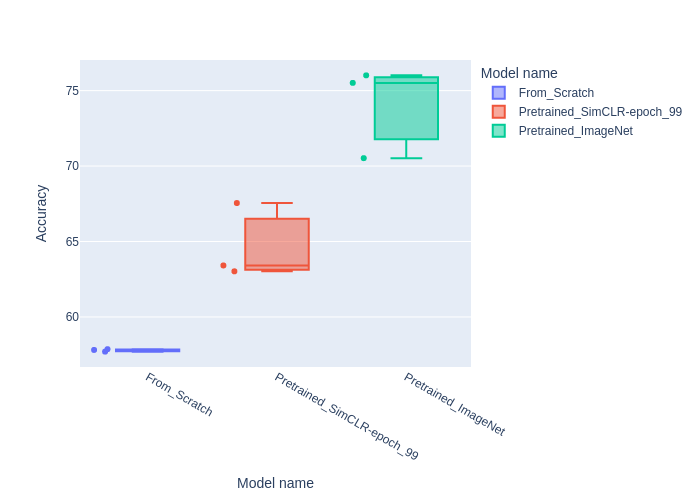

In [19]:
import plotly.express as px

# Configure the plotly renderer to use jupyterlab - you might print the 
# contents of the pio.renderers variable to check for other available 
# renderers (examples include: vscode, png, jpeg, pdf, ...)
import plotly.io as pio
pio.renderers.default = "png"
#print(pio.renderers)
#pio.renderers.default = "jupyterlab"

# Create and show the plot.
fig = px.box(df, x="Model name", y="Accuracy", color="Model name", points="all")
fig.show()

Notice that models with backbones pretrained on ImageNet consistently outperform the others.
Additionally, models using backbones pretrained with SimCLR for 20 epochs perform significantly better than those trained from scratch.

Although the SimCLR-pretrained backbones do not reach the performance level of those pretrained on ImageNet, it's important to highlight that they were pretrained for only 20 epochs—and notably, without the use of labels. 
This contrasts with ImageNet pretraining, which relies on extensive labeled data.

#### Note on Plotly box plots

Plotly offers a rich API that enables extensive customization and export of charts in various formats.
For example, the following code demonstrates how to adjust the display order of data categories, customize label formatting, and control the position of the legend.

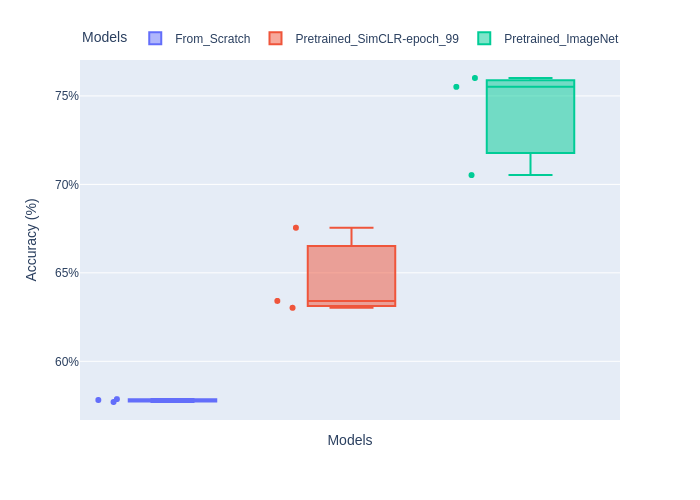

In [20]:
import plotly.express as px

# Create the plot.
fig = px.box(df, x="Model name", y="Accuracy", 
             color="Model name", points="all",
             category_orders={"Model name": ["From_Scratch", "Pretrained_SimCLR-epoch_99", "Pretrained_ImageNet"]},
             labels={"Model name": "Models", "Accuracy": "Accuracy (%)"}
             )
# Hide the group legend
fig.update_xaxes(showticklabels=False)
# Format y-axis values
fig.layout.yaxis.ticksuffix = '%'
# Format legend positioning.
fig.update_layout(legend=dict(
    orientation="h",
    yanchor="bottom",
    y=1.02,
    xanchor="left",
    x=0.0
))

fig.show()

## <a id="sec_7">7. Exercises</a>

### 7.1 Inspecting the Training Curves

Train the models for an extended number of epochs (e.g., 50 or 100) and examine the training and validation loss and accuracy curves using TensorBoard.

* What trends do you observe at the beginning and end of training?

* Are there noticeable differences in convergence or overfitting across different backbone types?

### 7.2 Freeze vs Full Fine-tuning

Modify the training procedure to include models where the backbone is frozen (i.e., only the prediction head is trained), and compare them to models with fully fine-tuned backbones.

* How does freezing the backbone impact performance across the different pretrained settings (Scratch, SimCLR, ImageNet)?

* What insights can you draw about the quality and transferability of the learned representations?

### 7.3 Qualitative evaluation of embeddings with t-SNE

Use the pretrained backbones to extract feature embeddings from the dataset, and visualize them using the t-SNE dimensionality reduction technique.

* How well-separated are the classes in the embedding space for each backbone type?

* What conclusions can you draw about the discriminative power of the learned representations?

### 7.4 Training with Limited Data

Train the models using only a small subset of the training dataset. 
Compare the performance of models with the following backbone types:
  - **From scratch**;
  - **Pretrained on ImageNet**; and 
  - **Pretrained with SimCLR**.

Try different data proportions such as 1%, 5%, 10%, 50%, and 100% of the training set.

* How does the amount of data affect the performance of each model?

* Which backbones are more robust in low-data regimes?

